# Experimenting with Cleaning, Clustering & Summarization Pipelines

### To do (technical)
- Implement date windows on my corpus loader function

In [1]:
import os
import re
import json
import hdbscan

import numpy as np
import pandas as pd
import networkx as nx

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from lib.helper import *
import lib.embedding_models as reps

from importlib import reload

%matplotlib inline

C:\Users\Martin\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\Martin\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# Should be same path for all my PC's, it's where each scrape goes as a separate json file.
storage_path = "C:/Users/Martin/Dropbox/news_crow/scrape_results"

# "bing" is targeted news search corpus, "RSS" is from specific world and local news feeds.
corpus_type = "bing"

## 0.  Build Corpus

The corpus is being scraped by the "run_news_scrapes.py" script (and windows task scheduler) every 12 hours, a bit past midday and a bit past midnight.

The "bing" corpus are news titles and text extracts gotten from the bing news search API, using a few Home Office - related keywords.

The "RSS" corpus is plugged directly into a number of RSS feeds for world news sites and local british news sites, with no filters for news story types or subjects applied.

### First, get a list of all the news dumps created so far

In [3]:
corpus = corpus_loader(storage_path, corpus_type)

Total files: 154
Loading file: bing_corpus_2019-09-05_2135.json
Loading file: bing_corpus_2019-09-06_0019.json
Loading file: bing_corpus_2019-09-06_1221.json
Loading file: bing_corpus_2019-09-07_0019.json
Loading file: bing_corpus_2019-09-07_1221.json
Loading file: bing_corpus_2019-09-08_0019.json
Loading file: bing_corpus_2019-09-08_1221.json
Loading file: bing_corpus_2019-09-09_0019.json
Loading file: bing_corpus_2019-09-09_1221.json
Loading file: bing_corpus_2019-09-10_0019.json
Loading file: bing_corpus_2019-09-10_1221.json
Loading file: bing_corpus_2019-09-11_0019.json
Loading file: bing_corpus_2019-09-11_1221.json
Loading file: bing_corpus_2019-09-12_0019.json
Loading file: bing_corpus_2019-09-12_1221.json
Loading file: bing_corpus_2019-09-13_0019.json
Loading file: bing_corpus_2019-09-13_1221.json
Loading file: bing_corpus_2019-09-14_0019.json
Loading file: bing_corpus_2019-09-14_1221.json
Loading file: bing_corpus_2019-09-15_0019.json
Loading file: bing_corpus_2019-09-15_2059.j

In [4]:
corpus.head()

,date,link,origin,retrieval_timestamp,source_url,summary,title
0,2019-09-05T17:32:00.0000000Z,https://www.desmoinesregister.com/story/opinio...,bing_news_api,2019-09-05 21:35:05.105002,www.desmoinesregister.com,<b>Immigration</b> raids are as devastating to...,<b>Immigration</b> raids are as devastating to...
1,2019-09-05T20:06:00.0000000Z,https://www.philstar.com/the-freeman/cebu-news...,bing_news_api,2019-09-05 21:35:05.105002,www.philstar.com,"CEBU, Philippines — The Department of Justice ...",<b>Immigration</b> told to monitor convicts: L...
2,2019-09-05T17:21:00.0000000Z,https://www.irishtimes.com/news/crime-and-law/...,bing_news_api,2019-09-05 21:35:05.106001,www.irishtimes.com,Three members of an organised crime gang were ...,Three people jailed for assisting illegal <b>i...
3,2019-09-05T20:12:00.0000000Z,https://www.correctionsone.com/immigration-det...,bing_news_api,2019-09-05 21:35:05.106001,www.correctionsone.com,"NATCHEZ, Miss. — A privately run prison in Mis...",<b>Immigration</b> agency sets new contract wi...
4,2019-09-05T19:27:00.0000000Z,https://www.nzherald.co.nz/nz/news/article.cfm...,bing_news_api,2019-09-05 21:35:05.106001,www.nzherald.co.nz,A licensed <b>immigration</b> adviser has been...,<b>Immigration</b> adviser censured and fined ...


## 1. Clean Text

By default, I'm not going to clean out all punctuation because I think it informs the POS tagger to some degree.

In [5]:
corpus['clean_text'] = corpus[['title', 'summary']].apply(lambda x: clean_text('.  '.join(x)), axis=1)

In [6]:
# Filter to only the .uk vendors
corpus = corpus[corpus['link'].str.contains(".uk/")]

In [7]:
corpus = corpus.drop_duplicates("clean_text")

In [8]:
corpus['clean_text'].head()

14    Government announces immigration plans for no ...
16    Home Secretary Priti Patel admits No Deal Brex...
28    Student film on immigration focuses on those m...
30    No deal immigration arrangements for EU citize...
31    AP EXPLAINS: What changed in 0 days of immigra...
Name: clean_text, dtype: object

In [9]:
corpus.shape

(5269, 8)

## 2.  Build Text Model (Representation, eg; word2vec, entities list...)

- Trying with the world corpus and with the bing corpus, neither worked with InferSent.  Suspect the problem lies in the PCA step, which may not be working well on this high-dimensional (vector length = 4096) form.
- Summed keywords works rather better with the world corpus.
- Summed keywords still fail the bing/home office corpus, giving me a cluster about "immigration" and a cluster for the American Supreme Court.

In [10]:
# Windows didn't play nicely with the vector datasets, Some obscure encoding problem (python in Conda
# kept trying to decode using cp1252 regardless of whatever other options I specified!)
# Solution; rewrite file and drop any characters the Windows encoder refuses to recognise.
# I shouldn't loose too much info.
#with open('./lib/InferSent/dataset/fastText/crawl-300d-2M.vec', "r", encoding="cp1252", errors="ignore") as infile:
#    with open('./lib/InferSent/dataset/fastText/crawl-300d-2M_win.vec', "wb") as outfile:
#        for line in infile:
#            outfile.write(line.encode('cp1252'))

In [11]:
#infersent = reps.InferSentModel(list(corpus['clean_text']),
#                                list(corpus['clean_text']),
#                                W2V_PATH = './lib/InferSent/dataset/fastText/crawl-300d-2M_win.vec')
#
#embeddings = infersent.get_embeddings()

In [12]:
# Whereas this worked first time!
#glove = reps.GloveWordModel(list(corpus['clean_text']), list(corpus['clean_text']))

#embeddings = glove.get_embeddings()

In [13]:
# Turn that into a DF for me
#embeddings_df = pd.DataFrame({"clean_text": list(embeddings.keys()),
#                              "embeddings": list(embeddings.values())})

## 3. Cluster Text

This is the part where the pipelines get a little more experimental

In [14]:
#embeddings_array = np.vstack(embeddings_df['embeddings'])

In [15]:
# First, PCA the data
#new_dims = 20

#pca = PCA(n_components=20, svd_solver='full')

#embeddings_pca = pca.fit_transform(embeddings_array)

In [16]:
#print(pca.explained_variance_ratio_)
#print(pca.singular_values_) 

In [17]:
#clusterer = hdbscan.HDBSCAN()

In [18]:
#clusterer.fit(embeddings_array)

In [19]:
#pd.unique(clusterer.labels_)

# Clustering using Entity Detection And Network Analytics

This doesn't resolve very well for Bing, because there's a whole bunch of keywords from the original searches in there.  Suspect that's got a lot to do with the failure of the other methods too.  For the network analytics method I'm going to try removing the keywords from the table first.

In [20]:
with open("C:/Users/Martin/Dropbox/news_crow/scrape_settings.json", "r") as f:
    scrape_config = json.load(f)

search_terms = scrape_config['search_list']
search_terms = re.sub(r"[^0-9A-Za-z ]", "", " ".join(search_terms)).lower().split()
search_terms = set(search_terms)

In [21]:
search_terms

{'abuse',
 'border',
 'child',
 'domestic',
 'enforcement',
 'force',
 'home',
 'immigration',
 'international',
 'office',
 'patel',
 'priti',
 'secretary',
 'students',
 'uk',
 'windrush'}

In [22]:
test = reps.NounAdjacencyModel(corpus['clean_text'], corpus['clean_text'])

In [23]:
test.noun_sets[4]

{'andrés',
 'ap',
 'city',
 'lópez',
 'manuel',
 'mexico',
 'obrador',
 'president',
 'trump',
 'u.s.',
 'year;s'}

In [24]:
nouns_df = test.table.copy()
nouns_df.head()

,c.,millington,aller,acre,newnham,cambridge,hackney,blackbird,constable,half,...,problem;.,risk’,sea,lancaster,palestine,police’,english_channel,martyn,investigation_cfi,cable
clean_text,,,,,,,,,,,,,,,,,,,,,
"Government announces immigration plans for no deal Brexit. New border controls that will make it harder for serious criminals to enter the UK will be introduced in the event of a no deal Brexit, the government has announced today (4 September). In a move signalling the end of free movement in its current form, a ...",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Home Secretary Priti Patel admits No Deal Brexit wouldn’t end unregulated EU immigration until 2021. PRITI PATEL tonight conceded unlimited EU immigration will all-but remain in place until 2021 in a No Deal. Despite promising tougher criminal checks on migrants from October 1, the Home Office said EU citizens would be allowed unfettered access to the UK ...",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Student film on immigration focuses on those making district their home. A STUDENT from Bradford has helped create a short film on immigration, featuring interviews with three people who have made the district their home. Ruby Blake, 22, who studied film and TV production at Northumbria University, was inspired to make the ...",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
No deal immigration arrangements for EU citizens moving to the UK after Brexit. The United Kingdom will be leaving the European Union on 1 October 201. This paper sets out the immigration arrangements that will apply to EU citizens and their family members who are moving to the UK after Brexit on 1 October 201 in the event that ...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"AP EXPLAINS: What changed in 0 days of immigration accord?. MEXICO CITY (AP) - Since last year;s caravans of Central American migrants began reaching the U.S. border, the Trump administration had been increasing pressure on Mexico President Andrés Manuel López Obrador to stop the flow of migrants. But it was the ...",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
print(nouns_df.shape)
for each in search_terms:
    try:
        nouns_df = nouns_df.drop(each, axis="columns")
    except:
        pass

print(nouns_df.shape)

embeddings = np.asarray(nouns_df)
adjacency = np.dot(embeddings, embeddings.T)
print(np.max(adjacency))

(5269, 6725)
(5269, 6710)
34


In [26]:
# If the "lower" limit is 1, the graph has so many edges it eats ALL the memory of my desktop, even
# with just 500-ish stories to process.
upper = 100
lower = 3
G = nx.Graph()
rows, cols = np.where((upper >= adjacency) & (adjacency >= lower))
weights = [float(adjacency[rows[i], cols[i]]) for i in range(len(rows))]
edges = zip(rows.tolist(), cols.tolist(), weights)
G.add_weighted_edges_from(edges)

In [27]:
G.number_of_edges()

21442

### Actually; the below is just the long way around to get the PageRank algorithm

Except that I've accounted for edge weights less well.  Oh well, live and learn... :)

In [28]:
net_degrees = dict(nx.degree(G))
degree_df = pd.DataFrame({"node": list(net_degrees.keys()), "degree": list(net_degrees.values())})
degree_df = degree_df.sort_values("degree", ascending=False)

for index, row in degree_df.head(10).iterrows():
    article = nouns_df.reset_index().iloc[index]
    print(row['degree'], article['clean_text'])

173 Boy, , sexually assaulted and girl, 12, raped in dating app meets. who was raped by a man she met on another dating app An 11-year-old girl who was coerced into sending naked pictures of herself over an app in Gwent A 12-year-old-girl in Hertfordshire who was groomed for sex after contact on Grindr Home secretary Priti ...
154 Home Office circulars 201. To help us improve GOV.UK, we’d like to know more about your visit today. We’ll send you a link to a feedback form. It will take only 2 minutes to fill in. Don’t worry we won’t send you spam or share your email address with anyone.
151 Domestic abuse thug Leon Thompson threatened to blow up girlfriend;s house if she revealed his vile attacks. Danielle Perry was left with post-traumatic stress disorder by bully who smashed her head through car windscreen. She said she wished she had left him the first time he raised his hands to her WARNING: GRAPHIC IMAGES OF INJURIES He beat her senseless and ...
148 Domestic Abuse Bill: six changes

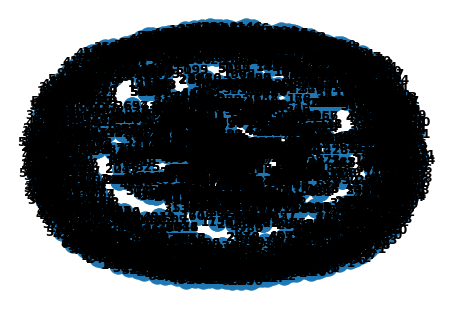

In [29]:
G_plot = nx.petersen_graph()
#plt.subplot(121)
nx.draw(G, with_labels=True, font_weight='bold')
#plt.subplot(122)
#nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

### Cliques, worth a look?
Idea from the docs, explanation at https://en.wikipedia.org/wiki/Clique_(graph_theory)

So, cliques are allowed to overlap - should've thought of that.  Still, good preliminary results and I've found I can disambiguate the cliques to some degree by cutting out weaker links (fewer shared entities).

I should add it also appears to merely suffer from the same problems as the other clustering methods, clusters are ultimately hierarchical!

In [30]:
cliques = []
for x in nx.find_cliques(G):
    x.sort()
    cliques.append((len(x), x))

In [31]:
cliques_df = pd.DataFrame({"nodes_list": [x[1] for x in cliques],
                           "clique_size": [x[0] for x in cliques]}).\
                    sort_values("clique_size", ascending=False).\
                    reset_index()

In [37]:
len(cliques_df[cliques_df['clique_size'] >= 30])

8

In [50]:
cliques_df[cliques_df['clique_size'] >= 10]

,index,nodes_list,clique_size
0,2916,"[94, 99, 146, 234, 264, 293, 308, 341, 395, 39...",50
1,78,"[61, 84, 123, 125, 145, 267, 403, 807, 822, 82...",39
2,527,"[387, 403, 624, 669, 671, 736, 890, 951, 954, ...",37
3,2831,"[669, 672, 673, 695, 957, 980, 1338, 1378, 138...",34
4,572,"[351, 397, 718, 925, 951, 957, 980, 1127, 1378...",33
5,2718,"[94, 99, 308, 341, 878, 925, 959, 1332, 2179, ...",31
6,2906,"[94, 99, 308, 341, 878, 925, 2272, 2510, 2641,...",30
7,281,"[181, 341, 391, 584, 672, 764, 825, 877, 974, ...",30
8,2372,"[2385, 2386, 2387, 2388, 2390, 2392, 2393, 239...",29
9,4,"[1, 64, 91, 134, 233, 618, 625, 708, 763, 1036...",29


In [44]:
for node in cliques_df.iloc[4]['nodes_list']:
    article = nouns_df.reset_index().iloc[node]
    print(article['clean_text'])

Only four cabinet ministers to deliver keynote speeches at Tory conference, as Government seeks to focus key election messages. Separate speaking slots have been reserved for Dominic Raab, the Foreign Secretary, Priti Patel, the Home Secretary, Sajid Javid, the Chancellor, and...
Priti Patel tells Sadiq Khan ;to spend his money on police not PR; after he blamed knife attacks on Tory cuts. The new Home Secretary challenged Sadiq Khan today over claims that he is wasting money on public relations that could go towards crime-fighting. In a letter to the Mayor, Priti Patel demanded his “personal reassurances that you are putting as much ...
Tory conference plans in disarray as Parliament blocks plan for recess. Keynote speeches are also due to be made by Chancellor Sajid Javid, Home Secretary Priti Patel, Foreign Secretary Dominic Raab and party chairman James Cleverly. Ahead of the defeat, a Tory source ...
Conservative Party conference agenda: what;s on today;s schedule for the Tory gath

Party Leaders Learn Just How Gruelling A December Election Can Be. The PM said his promised points-based immigration system “may” mean the numbers come down “in some sectors”. Home Secretary Priti Patel said a Tory government would “reduce immigration overall”. The European Commission has launched “infringement proceedings” against Britain after Johnson refused to nominate a new British EU ...
Boris Johnson appears to row back from Tory pledge to cut immigration. The Prime Minister said the Conservatives’ promised points-based immigration system “may” mean the numbers come down “in some sectors”. Earlier, however, Home Secretary Priti Patel said a Tory government would “reduce immigration overall”. At the same time ministers made clear they were finally abandoning the party’s long ...
How would the political parties approach immigration?. The Conservative pledges have prompted some confusion, however. Here are some of the key questions on the topic from the election campaign so far: Ho

In [46]:
for node in cliques_df.iloc[8]['nodes_list']:
    article = nouns_df.reset_index().iloc[node]
    print(article['clean_text'])

The people found dead in back of lorry were Chinese. On Wednesday, police searched two addresses in Northern Ireland as part of the investigation. The deaths follow warnings from the National Crime Agency (NCA) and the Border Force of the increased risk of people-smuggling via Belgium and into quieter ports such as Purfleet. The NCA previously said it had a “greater focus” on rising smuggler ...
Essex lorry deaths: 1 men and 8 women found dead believed to be Chinese nationals. On Wednesday, police searched two addresses in Northern Ireland as part of the investigation. The deaths follow warnings from the National Crime Agency (NCA) and the Border Force of the increased risk of people-smuggling via Belgium and into quieter ports such as Purfleet. The NCA previously said it had a quot;greater focusquot; on rising smuggler ...
1 Chinese men and eight women make up 8 bodies found in Essex lorry. He added: quot;We have no idea at the moment how long the lorry spent in Belgium, it could be h

Police start moving bodies of people found dead in lorry. Three addresses in Northern Ireland have also been searched as part of the investigation. The deaths follow warnings from the National Crime Agency (NCA) and Border Force about the increased risk of people-smuggling using quieter ports such as Purfleet and routes through Belgium. Tributes were left at the scene as a book of condolence was ...
Devon woman jailed for helping smuggle £8,000 worth of cocaine into UK. Sentencing followed a National Crime Agency (NCA) investigation which began when Sarwar – who has appeared in several grime music videos - was stopped by Border Force officers at St Pancras International Terminal in London on January 1 this year.
Devon woman jailed for helping smuggle £8,000 worth of cocaine into UK. Sentencing followed a National Crime Agency (NCA) investigation which began when Sarwar – who has appeared in several grime music videos - was stopped by Border Force officers at St Pancras International Te

In [54]:
for node in cliques_df.iloc[28]['nodes_list']:
    article = nouns_df.reset_index().iloc[node]
    print(article['clean_text'])

Labour to ;maintain and extend; EU free movement rights and close immigration centres. Priti Patel MP, Home Secretary, said: “Jeremy Corbyn does not believe in any limits on immigration. “Corbyn’s Labour even wants to extend free movement to more countries and allow potentially dangerous illegal immigrants to roam our streets.”
Home Secretary Priti Patel shames Corbyn for Labour;s ;dangerous; new immigration policy. Jeremy Corbyn will pledge to “maintain and extend” the free-movement rights of EU citizens at the next election after a vote at the party conference in Brighton. The vote on border control policy would also see all immigration detention centres close ...
Priti Patel’s brutal dig at Jeremy Corbyn and Dione Abbott receives thunderous applause. Brexiteer and Cabinet Member Priti Patel received deafening applause as she delivered her speech at the Tory Party Conference. Ms Patel ruthlessly mocked Jeremy Corbyn and Diane Abbott and the possibility of a Labour government. The Hom

General Election 201 latest updates: Jeremy Corbyn is ‘chilling’ risk to national security, claims Priti Patel. Priti Patel gave an exclusive interview to the Sun on Sunday revealing her fears over Jeremy Corbyn becoming Prime Minister. The Home Secretary said the Labour leader would be a quot;chillingquot; risk to national security if was in No 10. And Brexit Party boss Nigel Farage said again today his candidates, including Ann Widdecombe, had been offered ...
General Election 201: Labour leader Jeremy Corbyn is ‘chilling’ risk to national security, reveals Home Secretary. HOME Secretary gave an exclusive interview to the Sun on Sunday where she revealed her fears if JEremy Corbyn became Prime Minister. Priti Patel said the Labour leader would be a quot;chillingquot; risk to national security if was in No 10. She fears his past ...


In [53]:
for node in cliques_df.iloc[450]['nodes_list']:
    article = nouns_df.reset_index().iloc[node]
    print(article['clean_text'])

MP Philip Davies calls for doubled sentences for police attacks. quot;The draft guidelines will be subject to the Council’s usual full public consultation process.quot; Meanwhile the Government said the Home Secretary, MP Priti Patel, has spoken out about the need for better protection and stronger sentences. A Government ...
PM ‘accepts’ Government cuts have contributed to violent crime rise – Sadiq Khan. The mayor of London claimed that former prime ministers had resisted taking responsibility for the rise in violence, but Boris Johnson, and new Home Secretary Priti Patel, have “woken up” to the issues. Speaking on the BBC’s Andrew Marr Show ...
Boris Johnson says he wants victims of crime to feel they are protected, cared for and safe – not abandoned by the state. WHEN she became Home Secretary, Priti Patel said she wanted criminals to “feel terror”. She’s right of course — this Government wants criminals to be met by more police on the street and face tougher sentences once they’re